COMP2200 - Brianna Lindsay 45428239

In [1]:
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns
import collections
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
sns.set(rc={'figure.figsize':(16,10)})
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation and 

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

##### Variables and their descriptions

| Lable   | description                           |
|---------|---------------------------------------|
| wid     | Wikipedia article ID                  |
| fid     | Freebase ID                           |
| title   | Book title                            |
| author  | Author                                |
| date    | Publication date                      |
| genres  | Book genres (Freebase ID:name tuples) |
| summary | Plot summary                          |

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv('data/booksummaries.txt', sep="\t", header=None, names=names, keep_default_na=False)

# removes books that dont have summaries
books = books[books['summary']!= '']

books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


([<matplotlib.axis.XTick at 0x28a609e2460>,
 [Text(0, 0, 'Fiction'),
  Text(0, 0, 'Speculative fiction'),
  Text(0, 0, 'Science Fiction'),
  Text(0, 0, 'Novel'),
  Text(0, 0, 'Fantasy'),
  Text(0, 0, 'Mystery'),
  Text(0, 0, 'Young adult literature'),
  Text(0, 0, 'Suspense'),
  Text(0, 0, 'Crime Fiction'),
  Text(0, 0, 'Historical novel')])

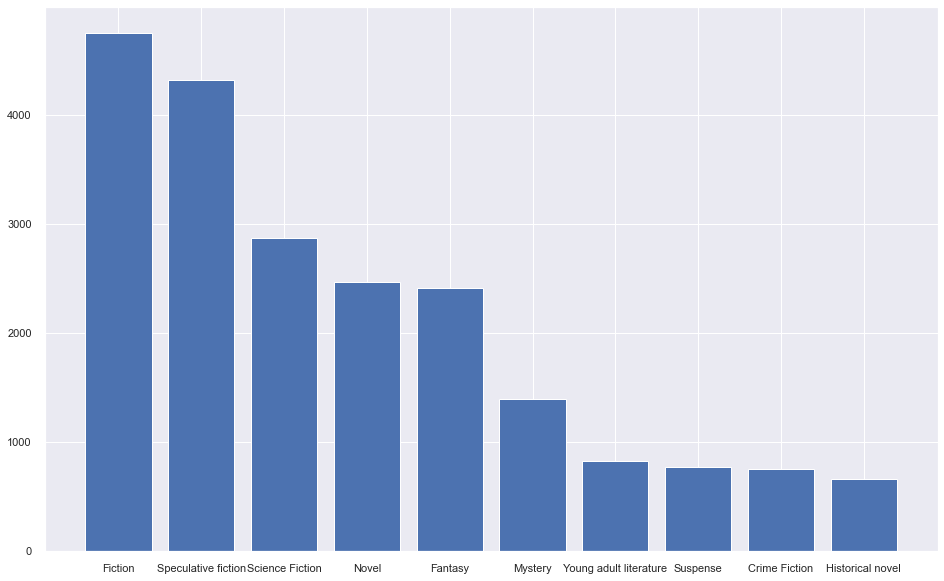

In [3]:
# function to clean genres
def clean(string):
    return re.findall('"([\w\s]+)"', string)

#clean genres
books['genres']=books['genres'].apply(str)
gen = books['genres'].apply(clean)

# creates a dictionary for all genres
genDict = {}
for i in gen:
    for k in i:
        if k not in genDict:
            genDict[k] = 1
        else:
            genDict[k] += 1
            
# selects the top 10 genres
top10 = dict(Counter(genDict).most_common(10))

# graphs top 10 genres
plt.bar(range(len(top10)), top10.values(), align="center")
plt.xticks(range(len(top10)), list(top10.keys()))

We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [4]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))

# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
books['genre'] = genre

# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [5]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [6]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre_books.summary)
y = genre_books.genre

## Model Training

Then, train two predictive models from the given data set.

*inorder to retain as much comparability of the models the training and testing data is the same for all models.*

In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

# check the shape of train and test
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

# range to check models predictions
ran = [0,1,2,3,4]

# find the genres of our check train sets
y_new_pred = y_train.head()
y_new_pred

X_train shape: (7163, 88356)
y_train shape: (7163,)
X_test shape: (1791, 88356)
y_test shape: (1791,)


12704          Science Fiction
11452          Science Fiction
8718                     Novel
9581     Children's literature
9855                     Novel
Name: genre, dtype: object

### KNeighbors classifier
looks for the closest 5 neighbors in a dataframe.

In [8]:
# create and train a KN classifier model
clf_knn = KNeighborsClassifier()

# train the model
clf_knn.fit(X_train,y_train)

KNeighborsClassifier()

##### test model is working with first 5 rows of data

In [9]:
# Predict the genre of X_train[0]:
for x in ran:
    y_new_pred[x] = clf_knn.predict(X_train[x])
print("The predicted class is for first row of data :", y_new_pred[0])
print("The predicted class is for second row of data :", y_new_pred[1])
print("The predicted class is for third row of data :", y_new_pred[2])
print("The predicted class is for forth row of data :", y_new_pred[3])
print("The predicted class is for fith row of data :", y_new_pred[4])

The predicted class is for first row of data : ['Novel']
The predicted class is for second row of data : ['Novel']
The predicted class is for third row of data : ['Novel']
The predicted class is for forth row of data : ["Children's literature"]
The predicted class is for fith row of data : ['Novel']


### Gaussian Naive Bayes
based off the Bayes theorem, this model is based off probability of each of the classes based on the factors

In [10]:
clf_gnb = GaussianNB()
X_trainD = X_train.todense()
clf_gnb.fit(X_trainD, y_train)

GaussianNB()

##### test model is working with first 5 rows of data

In [11]:
# predict the genre of X_train[0]
for x in ran:
    y_new_pred[x] = clf_gnb.predict(X_trainD[x])
print("The predicted class is for first row of data :", y_new_pred[0])
print("The predicted class is for second row of data :", y_new_pred[1])
print("The predicted class is for third row of data :", y_new_pred[2])
print("The predicted class is for forth row of data :", y_new_pred[3])
print("The predicted class is for fith row of data :", y_new_pred[4])

The predicted class is for first row of data : ['Science Fiction']
The predicted class is for second row of data : ['Science Fiction']
The predicted class is for third row of data : ['Novel']
The predicted class is for forth row of data : ["Children's literature"]
The predicted class is for fith row of data : ['Novel']


### Multinomial Naive bayes
is also based on the Bayes theorm, it utilises term frequency as part of the probibility calculating the maximum likelihood estimates could be.

In [12]:
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train, y_train)

MultinomialNB()

##### test model is working with first 5 rows of data

In [13]:
for x in ran:
    y_new_pred[x] = clf_mnb.predict(X_trainD[x])
print("The predicted class is for first row of data :", y_new_pred[0])
print("The predicted class is for second row of data :", y_new_pred[1])
print("The predicted class is for third row of data :", y_new_pred[2])
print("The predicted class is for forth row of data :", y_new_pred[3])
print("The predicted class is for fith row of data :", y_new_pred[4])

The predicted class is for first row of data : ['Science Fiction']
The predicted class is for second row of data : ['Science Fiction']
The predicted class is for third row of data : ['Novel']
The predicted class is for forth row of data : ['Novel']
The predicted class is for fith row of data : ['Novel']


### LogisticRegression
is a model based on the logistic function of a binary dependent variable.

In [14]:
clf_lr = LogisticRegression()
clf_lr = clf_lr.fit(X_train, y_train)

##### test model is working with first 5 rows of data

In [15]:
for x in ran:
    y_new_pred[x] = clf_lr.predict(X_train[x])
print("The predicted class is for first row of data :", y_new_pred[0])
print("The predicted class is for second row of data :", y_new_pred[1])
print("The predicted class is for third row of data :", y_new_pred[2])
print("The predicted class is for forth row of data :", y_new_pred[3])
print("The predicted class is for fith row of data :", y_new_pred[4])

The predicted class is for first row of data : ['Science Fiction']
The predicted class is for second row of data : ['Science Fiction']
The predicted class is for third row of data : ['Novel']
The predicted class is for forth row of data : ["Children's literature"]
The predicted class is for fith row of data : ['Novel']


## Model Evaluation

Finally, evaluate and compare the learned predictive models.

### KNeigbours classifier
this model has a very low accuracy model at 50.59% accuracy rate meaning its isnt going to predict the genre of a book based on the summary correctly very often. 
when we look at the confusion matrix (and the heat map, showcasing the confusion matrix in a clearer format) we can see the break down of actual vs predicted. 
* Children's literature: was predicted correctly 94 times however a significant proportion of times it was predicted as fantasy (73) and science Fiction (51)
* Science Fiction: was predicted accuratly 254 times with it being incorrectly predictedd as mainly fanasy(48) and mystery(40)
* Novel: was predicted 130 times accuratly  and was mainly incorrectly predicted as Fantasy(64)
* Fantasy: was predicted accuratly 281 times and was mainly incorrectly predicted as mystery (46)
* Mystery: was predicted accuratly 161 times and was predicted incorrectly mostly as Fantasy(44) and science fiction(42)

looking at the classification report 
* precision (accuracy of the predictions) was best for mystery at 63% while worse at Children's literature and Novel
* recall (how many of this class you find over the whole number of element of this class): Novel is the most common while Fantasy(0.55), Mystery(0.47) and Science fiction(0.45) all have simillar recall values, finally childrens literature is smallest at 0.35)
* F1-score (percent of correct predictions) childrens literature is verry inaccurate at 38%, while the other genres all have similar f1 scores between 49%-58% with the most accuract being fantasy(58%)
* support (accutual occurrences of genres) fantasy and novel appeared the most around 460 occurances with science fiction appearing 359 time and mystery and childrens literature being least frequent at 279 & 229 respectivly 

In [16]:
# use the model to predict testing data
y_pred = clf_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy of test equals", accuracy)


accuracy of test equals 0.5058626465661642


In [17]:
print("confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Metric Report: \n",classification_report(y_test,y_pred))

confusion Matrix: 
 [[ 80  34  19  79  17]
 [ 27 254  12 123  44]
 [ 17  30 130  87  15]
 [ 55  50  36 281  42]
 [ 17  54  10 117 161]]
Performance Metric Report: 
                        precision    recall  f1-score   support

Children's literature       0.41      0.35      0.38       229
              Fantasy       0.60      0.55      0.58       460
              Mystery       0.63      0.47      0.53       279
                Novel       0.41      0.61      0.49       464
      Science Fiction       0.58      0.45      0.50       359

             accuracy                           0.51      1791
            macro avg       0.52      0.48      0.50      1791
         weighted avg       0.53      0.51      0.51      1791



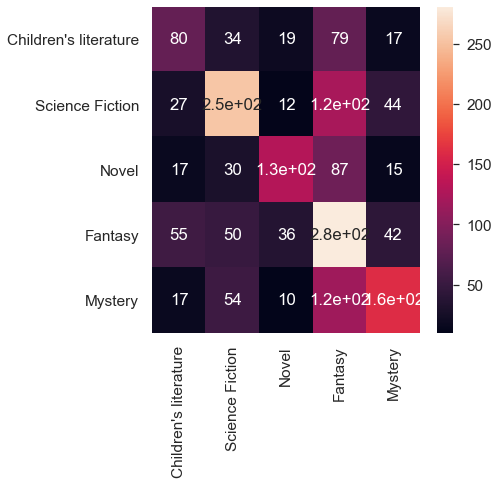

In [18]:
# create heatmap based on confusion matrixs as it is clearer to understand
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in target_genres],
                  columns = [i for i in target_genres])
plt.figure(figsize=(6,6))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot=True)

### Gaussian Naive Bayes
this model has a very low accuracy model at 50% accuracy rate meaning its isnt going to predict the genre of a book based on the summary correctly very often. 
when we look at the confusion matrix (and the heat map, showcasing the confusion matrix in a clearer format) we can see the break down of actual vs predicted. 
* Children's literature: was predicted correctly 59 times however a significant proportion of times it was predicted as fantasy (78) and science Fiction (53)
* Science Fiction: was predicted accuratly 300 times with it being incorrectly predictedd as mainly as fanasy(72) and mystery(50)
* Novel: was predicted 106 times accuratly  and was mainly incorrectly predicted as Fantasy(72)
* Fantasy: was predicted accuratly 247 times and was mainly incorrectly predicted as science fiction (82) and mystery (72)
* Mystery: was predicted accuratly 185 times and was predicted incorrectly mostly as Fantasy(80) and science fiction(71)
the confusion matrics for GNB was very similar to KNN

looking at the classification report 
* precision (accuracy of the predictions) was best for fantasy at 55% while worse for Children's literature and Novel  46% and 43% respecitivly
* recall (how many of this class you find over the whole number of element of this class): Fantasy is the most common(0.65) while Novel(0.53), and Science fiction(0.52) have simillar recall values, finally childrens literature & mystery are the smallest at 0.2.6 & 0.38 respectivly 
* F1-score (percent of correct predictions) childrens literature is verry inaccurate at 33%, while the other genres all have similar f1 scores between 48%-60% with the most accuract being fantasy(60%)
* support (accutual occurrences of genres) fantasy and novel appeared the most around 460 occurances with science fiction appearing 359 time and mystery and childrens literature being least frequent at 279 & 229 respectivly


In [19]:
# use the model to predict testing data
y_pred = clf_gnb.predict(X_test.todense())
accuracy = accuracy_score(y_test, y_pred)
print("accuracy of test equals", accuracy)

accuracy of test equals 0.5008375209380235


In [20]:
print("confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Metric Report: \n",classification_report(y_test,y_pred))

confusion Matrix: 
 [[ 59  53  20  78  19]
 [ 24 300  14  72  50]
 [ 17  35 106  92  29]
 [ 20  82  43 247  72]
 [  8  71  15  80 185]]
Performance Metric Report: 
                        precision    recall  f1-score   support

Children's literature       0.46      0.26      0.33       229
              Fantasy       0.55      0.65      0.60       460
              Mystery       0.54      0.38      0.44       279
                Novel       0.43      0.53      0.48       464
      Science Fiction       0.52      0.52      0.52       359

             accuracy                           0.50      1791
            macro avg       0.50      0.47      0.47      1791
         weighted avg       0.50      0.50      0.49      1791



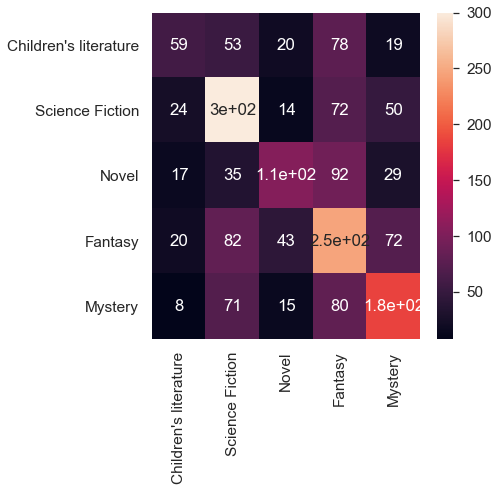

In [21]:
# create heatmap based on confusion matrixs as it is clearer to understand
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in target_genres],
                  columns = [i for i in target_genres])
plt.figure(figsize=(6,6))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot=True)

In [22]:
# Explore the learned probability (model parameters)
print('Estimated probability of classess: \n', clf_gnb.class_prior_)
print('Estimated mean for each Gaussian distribution: \n', clf_gnb.theta_)
print('Estimated variance for each Gaussian distribution: \n', clf_gnb.sigma_)

Estimated probability of classess: 
 [0.12048025 0.25841128 0.15594025 0.25045372 0.21471451]
Estimated mean for each Gaussian distribution: 
 [[0.00000000e+00 3.35354381e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.62592889e-05 6.47376488e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.65163750e-04 1.34676558e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.71391462e-04 7.87114576e-04 0.00000000e+00 ... 0.00000000e+00
  2.22471996e-05 2.22471996e-05]
 [5.80018069e-05 2.26123228e-03 1.49850461e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Estimated variance for each Gaussian distribution: 
 [[7.33962502e-12 1.28165362e-05 7.33962502e-12 ... 7.33962502e-12
  7.33962502e-12 7.33962502e-12]
 [4.89081621e-07 3.48821339e-05 7.33962502e-12 ... 7.33962502e-12
  7.33962502e-12 7.33962502e-12]
 [2.12912448e-05 7.76978107e-05 7.33962502e-12 ... 7.33962502e-12
  7.33962502e-12 7.33962502e-12]
 [1.3121942

### Multinomial Naive bayes
this model has a very low accuracy model at 55.5% accuracy rate meaning its isnt going to predict the genre of a book based on the summary correctly very often. 
when we look at the confusion matrix (and the heat map, showcasing the confusion matrix in a clearer format) we can see the break down of actual vs predicted. 
* Children's literature: wasnt predicted at all while science fiction and fantasy were predicted inaccuratly 105 & 124 times respectivly
* Science Fiction: was predicted accuratly 391 times with it being incorrectly predictedd as mainly as fanasy(51)
* Novel: was predicted 26 times accuratly and was mainly incorrectly predicted as Fantasy(191)
* Fantasy: was predicted accuratly 395 times and was mainly incorrectly predicted as science fiction (48)
* Mystery: was predicted accuratly 182 times and was predicted incorrectly mostly as Fantasy(66) and science fiction(111)
this model mainly predicted science fiction and fantasy

looking at the classification report 
* precision (accuracy of the predictions) was best for Mystery at 93% and science fiction at 81% while worse for Children's literature as it wasnt predicted at all
* recall (how many of this class you find over the whole number of element of this class): Fantasy & Novel,  are the most common(0.85), Science fiction had a score of (0.51). while children's literature and mystery had very low socres around 0.09-0. 
* F1-score (percent of correct predictions) childrens literature is very inaccurate at 0%, with fantasy, novel and science fiction had similar F1 socres around 60-70%
* support (accutual occurrences of genres) fantasy and novel appeared the most around 460 occurances with science fiction appearing 359 time and mystery and childrens literature being least frequent at 279 & 229 respectivly


In [23]:
# use the model to predict testing data
y_pred = clf_mnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy of test equals", accuracy)

accuracy of test equals 0.5549972082635399


In [24]:
print("confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Metric Report: \n",classification_report(y_test,y_pred))

confusion Matrix: 
 [[  0 105   0 124   0]
 [  0 391   1  51  17]
 [  0  57  26 191   5]
 [  0  48   1 395  20]
 [  0 111   0  66 182]]
Performance Metric Report: 
                        precision    recall  f1-score   support

Children's literature       0.00      0.00      0.00       229
              Fantasy       0.55      0.85      0.67       460
              Mystery       0.93      0.09      0.17       279
                Novel       0.48      0.85      0.61       464
      Science Fiction       0.81      0.51      0.62       359

             accuracy                           0.55      1791
            macro avg       0.55      0.46      0.41      1791
         weighted avg       0.57      0.55      0.48      1791



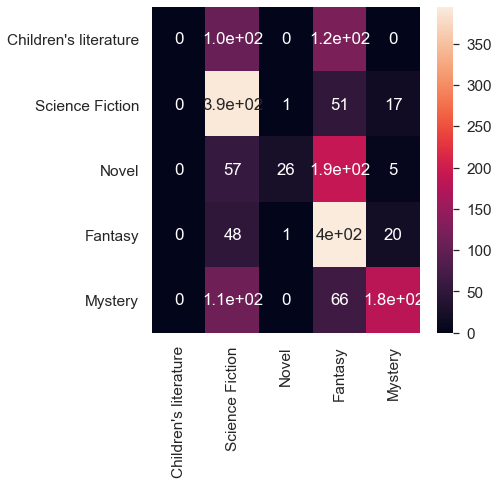

In [25]:
# create heatmap based on confusion matrixs as it is clearer to understand
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in target_genres],
                  columns = [i for i in target_genres])
plt.figure(figsize=(6,6))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot=True)

In [26]:
print('Estimated probability of classess: \n', np.e**clf_mnb.class_log_prior_)
print('Estimated class-conditional probabilities for each feature: \n', np.e**clf_mnb.feature_log_prob_)

Estimated probability of classess: 
 [0.12048025 0.25841128 0.15594025 0.25045372 0.21471451]
Estimated class-conditional probabilities for each feature: 
 [[1.04711076e-05 1.35015596e-05 1.04711076e-05 ... 1.04711076e-05
  1.04711076e-05 1.04711076e-05]
 [9.79542381e-06 2.09040918e-05 9.50923443e-06 ... 9.50923443e-06
  9.50923443e-06 9.50923443e-06]
 [1.32506444e-05 2.56012888e-05 1.02227804e-05 ... 1.02227804e-05
  1.02227804e-05 1.02227804e-05]
 [1.25278061e-05 2.31117882e-05 9.58166983e-06 ... 9.58166983e-06
  9.96408842e-06 9.96408842e-06]
 [1.06530125e-05 4.37949863e-05 1.20346409e-05 ... 9.78052354e-06
  9.78052354e-06 9.78052354e-06]]


### LogisticRegression
this model has a very low accuracy model at 69.74% accuracy rate meaning its isnt going to predict the genre of a book based on the summary correctly very often. 
when we look at the confusion matrix (and the heat map, showcasing the confusion matrix in a clearer format) we can see the break down of actual vs predicted. 
* Children's literature: was correctly predicted 94 times and mainly incorrectly predicted as Fantasy
* Science Fiction: was predicted accuratly 352 times with it being incorrectly predicted as mainly as fanasy(48) and Mystery (40)
* Novel: was predicted 184 times accuratly and was mainly incorrectly predicted as Fantasy(64)
* Fantasy: was predicted accuratly 363 times and was mainly incorrectly predicted as mystery (46)
* Mystery: was predicted accuratly 256 times and was predicted incorrectly mostly as Fantasy(44) and science fiction(42)

looking at the classification report 
* precision (accuracy of the predictions) was best for Mystery at 82% and science fiction at 73% while the other 3 genres were around 72%
* recall (how many of this class you find over the whole number of element of this class): Fantasy, Mystery and science fiction are the most common around 0.79 with children literrature around 0.41.
* F1-score (percent of correct predictions) childrens literature score was 52%, while the other genres were around 70%
* support (accutual occurrences of genres) fantasy and novel appeared the most around 460 occurances with science fiction appearing 359 time and mystery and childrens literature being least frequent at 279 & 229 respectivly


In [27]:
# use the model to predict testing data
y_pred = clf_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy of test equals", accuracy)

accuracy of test equals 0.6973757677275265


In [28]:
print("confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Metric Report: \n",classification_report(y_test,y_pred))

confusion Matrix: 
 [[ 94  51  10  73   1]
 [ 15 352   5  48  40]
 [  2  20 184  64   9]
 [ 13  25  17 363  46]
 [  9  42   8  44 256]]
Performance Metric Report: 
                        precision    recall  f1-score   support

Children's literature       0.71      0.41      0.52       229
              Fantasy       0.72      0.77      0.74       460
              Mystery       0.82      0.66      0.73       279
                Novel       0.61      0.78      0.69       464
      Science Fiction       0.73      0.71      0.72       359

             accuracy                           0.70      1791
            macro avg       0.72      0.67      0.68      1791
         weighted avg       0.71      0.70      0.69      1791



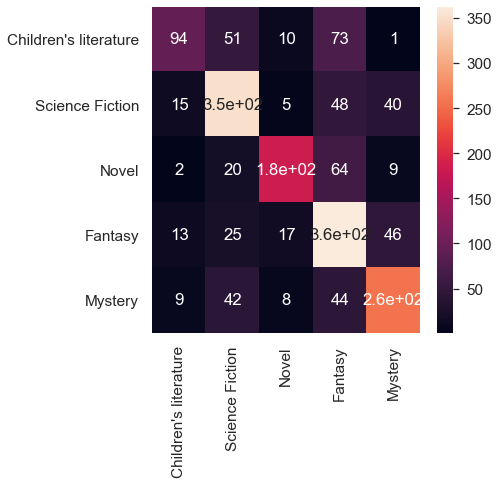

In [29]:
# create heatmap based on confusion matrixs as it is clearer to understand
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in target_genres],
                  columns = [i for i in target_genres])
plt.figure(figsize=(6,6))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot=True)

### conclusion 
In conclusion this project had two main findings: 
* all of the models did a better job at predicting Fantasy than all other genres while children's litrature was the least accurate, this is likely due to being such a small sample size, when compared to the other genres
* the best model for predicting the genes based on the summary of books out of the 4 models tested was the Logistic Regression model as it had the highest accuracy for all of the genes